- 세그먼트 : 이미지를 여러개의 영역으로 나누는 작업으로 컴퓨터의 비전 및 이미지 처리에 사용
  - 이진 세그먼트
  - 다중 클래스 세그먼트
  - 인스턴스 세그먼트
    - 같은 클래스의 객체를 개별적으로 구분
  - 파노라믹 세그먼트
    - 인스턴스 세그먼트와 픽셀 분류의 조합, 모든 픽셀을 객체로 할당하거나 배경으로 분류

참고 자료 : https://www.tensorflow.org/tutorials/images/segmentation?hl=ko

In [54]:
import tensorflow as tf
data_url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
data_dir = tf.keras.utils.get_file(origin=data_url, extract=True)

In [56]:
import tarfile
import os
# Extract the .tar.gz file manually
if data_dir.endswith('.tar.gz'):
    # Open the downloaded .tar.gz file and extract it
    with tarfile.open(data_dir, "r:gz") as tar_ref:
        tar_ref.extractall(os.path.dirname(data_dir))

    # Check where the data was extracted
    extracted_dir = os.path.join(os.path.dirname(data_dir), 'images')
    print(f"Data extracted to: {extracted_dir}")
else:
    print("The downloaded file is not in the correct format.")

Data extracted to: /root/.keras/datasets/images


In [57]:
os.listdir(extracted_dir)

['english_setter_171.jpg',
 'pomeranian_27.jpg',
 'Ragdoll_170.jpg',
 'Bombay_18.jpg',
 'american_pit_bull_terrier_106.jpg',
 'american_pit_bull_terrier_31.jpg',
 'english_setter_13.jpg',
 'samoyed_114.jpg',
 'american_bulldog_37.jpg',
 'english_setter_78.jpg',
 'Russian_Blue_154.jpg',
 'great_pyrenees_132.jpg',
 'pomeranian_44.jpg',
 'Sphynx_40.jpg',
 'keeshond_161.jpg',
 'Bengal_185.jpg',
 'Ragdoll_141.jpg',
 'Bengal_12.jpg',
 'Russian_Blue_19.jpg',
 'american_pit_bull_terrier_92.jpg',
 'Birman_38.jpg',
 'boxer_9.jpg',
 'shiba_inu_35.jpg',
 'British_Shorthair_273.jpg',
 'wheaten_terrier_176.jpg',
 'staffordshire_bull_terrier_140.jpg',
 'Persian_102.jpg',
 'British_Shorthair_266.jpg',
 'British_Shorthair_104.jpg',
 'english_cocker_spaniel_100.jpg',
 'saint_bernard_24.jpg',
 'beagle_108.jpg',
 'havanese_198.jpg',
 'chihuahua_91.jpg',
 'Persian_82.jpg',
 'saint_bernard_127.jpg',
 'shiba_inu_51.jpg',
 'staffordshire_bull_terrier_38.jpg',
 'havanese_110.jpg',
 'Ragdoll_228.jpg',
 'Bombay_

In [60]:
data_url = "http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"
data_dir = tf.keras.utils.get_file(origin=data_url, extract=True)
import tarfile
import os
# Extract the .tar.gz file manually
if data_dir.endswith('.tar.gz'):
    # Open the downloaded .tar.gz file and extract it
    with tarfile.open(data_dir, "r:gz") as tar_ref:
        tar_ref.extractall(os.path.dirname(data_dir))

    # Check where the data was extracted
    extracted_dir_annotations = os.path.join(os.path.dirname(data_dir), 'annotations')
    print(f"Data extracted to: {extracted_dir_annotations}")
else:
    print("The downloaded file is not in the correct format.")

Data extracted to: /root/.keras/datasets/annotations


In [62]:
os.listdir(extracted_dir_annotations+'/trimaps')

['._Birman_7.png',
 'havanese_148.png',
 '._staffordshire_bull_terrier_154.png',
 '._pug_172.png',
 '._Persian_264.png',
 'shiba_inu_19.png',
 '._saint_bernard_25.png',
 'english_setter_69.png',
 '._Russian_Blue_45.png',
 '._yorkshire_terrier_81.png',
 'havanese_103.png',
 '._american_bulldog_191.png',
 'Bombay_150.png',
 'samoyed_131.png',
 'great_pyrenees_2.png',
 'keeshond_143.png',
 '._Bengal_93.png',
 '._german_shorthaired_84.png',
 '._american_pit_bull_terrier_202.png',
 'leonberger_155.png',
 'yorkshire_terrier_53.png',
 '._wheaten_terrier_115.png',
 'Sphynx_89.png',
 'Siamese_231.png',
 'Maine_Coon_101.png',
 'boxer_134.png',
 'wheaten_terrier_127.png',
 'Persian_103.png',
 'Sphynx_165.png',
 'Abyssinian_133.png',
 '._Bombay_136.png',
 'leonberger_66.png',
 'pomeranian_69.png',
 'keeshond_8.png',
 '._Persian_95.png',
 'boxer_133.png',
 'Bengal_164.png',
 '._British_Shorthair_62.png',
 '._japanese_chin_96.png',
 'Bombay_75.png',
 '._basset_hound_138.png',
 'Russian_Blue_140.png'

In [65]:
input_dir = extracted_dir
target_dir = extracted_dir_annotations+'/trimaps'
img_size = (160,160)
num_classes = 4
batch_size = 32
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

In [66]:
print(len(input_img_paths), len(target_img_paths))

7390 7390


In [69]:
[ (input_path, target_path) for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10])]

[('/root/.keras/datasets/images/Abyssinian_1.jpg',
  '/root/.keras/datasets/annotations/trimaps/Abyssinian_1.png'),
 ('/root/.keras/datasets/images/Abyssinian_10.jpg',
  '/root/.keras/datasets/annotations/trimaps/Abyssinian_10.png'),
 ('/root/.keras/datasets/images/Abyssinian_100.jpg',
  '/root/.keras/datasets/annotations/trimaps/Abyssinian_100.png'),
 ('/root/.keras/datasets/images/Abyssinian_101.jpg',
  '/root/.keras/datasets/annotations/trimaps/Abyssinian_101.png'),
 ('/root/.keras/datasets/images/Abyssinian_102.jpg',
  '/root/.keras/datasets/annotations/trimaps/Abyssinian_102.png'),
 ('/root/.keras/datasets/images/Abyssinian_103.jpg',
  '/root/.keras/datasets/annotations/trimaps/Abyssinian_103.png'),
 ('/root/.keras/datasets/images/Abyssinian_104.jpg',
  '/root/.keras/datasets/annotations/trimaps/Abyssinian_104.png'),
 ('/root/.keras/datasets/images/Abyssinian_105.jpg',
  '/root/.keras/datasets/annotations/trimaps/Abyssinian_105.png'),
 ('/root/.keras/datasets/images/Abyssinian_106

이미지확인

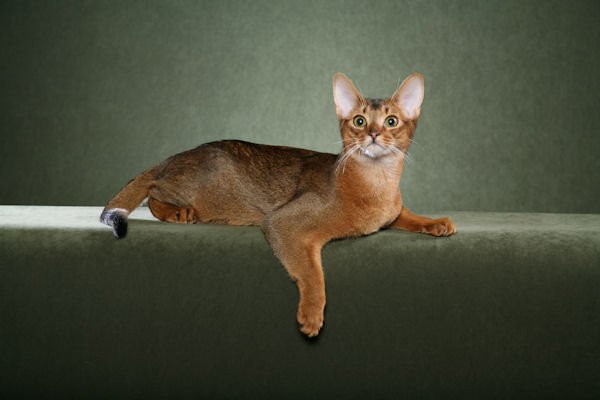

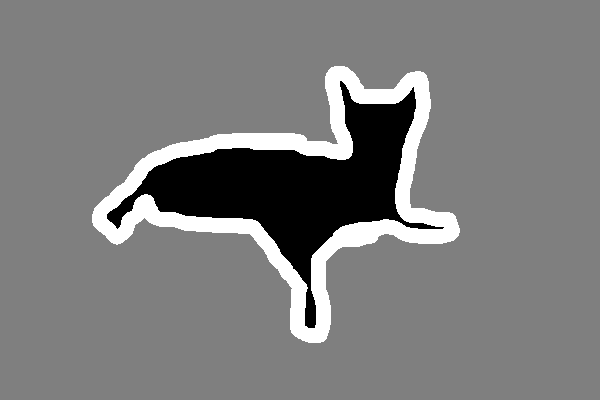

In [72]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

display(Image(filename=input_img_paths[0]))
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[0]))
display(img)